# Import required Libraries

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import difflib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Load the Dataset

In [2]:
# Load Dataset
df = pd.read_csv("resources/SpotifyFeatures.csv")
# View basic info
df.info()  # Check column types & missing values
df.head()  # Preview first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


# Data Preprocessing

In [3]:
# Preprocess Data
df["mode"] = df["mode"].map({"Major": 1, "Minor": 0})  # Convert Major/Minor to numeric

# Encode artist names into numeric values
artist_encoder = LabelEncoder()
df["artist_encoded"] = artist_encoder.fit_transform(df["artist_name"])

# Select numeric features, including artist encoding
numeric_features = ["danceability", "energy", "tempo", "acousticness",
                    "instrumentalness", "valence", "loudness", "mode", "artist_encoded"]

# Sample subset for efficiency
df_sample = df.sample(5000, random_state=42).reset_index(drop=True)


# Feature Scaling

In [4]:
# Scale features
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(scaler.fit_transform(df_sample[numeric_features]), columns=numeric_features)

# Apply PCA for Dimensionality Reduction

In [5]:
# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=7)  
X_pca = pca.fit_transform(X_scaled_df)
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.2f}")  # Check variance retention

# Create DataFrame for PCA results
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"])
pca_df["artist_name"] = df_sample["artist_name"].values
pca_df["original_index"] = df_sample.index  # Keep original index for mapping clusters
pca_df.head()  # Preview PCA DataFrame

Explained Variance Ratio: 0.95


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,artist_name,original_index
0,1.076249,1.910780,-0.160738,-2.397920,0.203782,-0.202425,-0.379842,A Thousand Horses,0
1,-3.887190,0.648977,0.688820,-0.007213,-0.109699,0.013537,0.098036,Mark Mothersbaugh,1
2,2.198608,-0.145844,-0.514408,2.012272,0.847879,-0.091408,0.170716,Unified Highway,2
3,1.337822,0.939832,0.786506,0.496775,-0.705776,-0.011333,1.569543,Stooki Sound,3
4,-0.811251,-0.344022,0.125106,-1.735560,-0.599246,-0.616428,-0.278132,Bill Hicks,4


# Apply K-Means Clustering

In [6]:
# Perform K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_sample["Cluster"] = kmeans.fit_predict(X_pca)

# Merge Cluster Labels into PCA DataFrame
pca_df["Cluster"] = df_sample.loc[pca_df["original_index"], "Cluster"].values


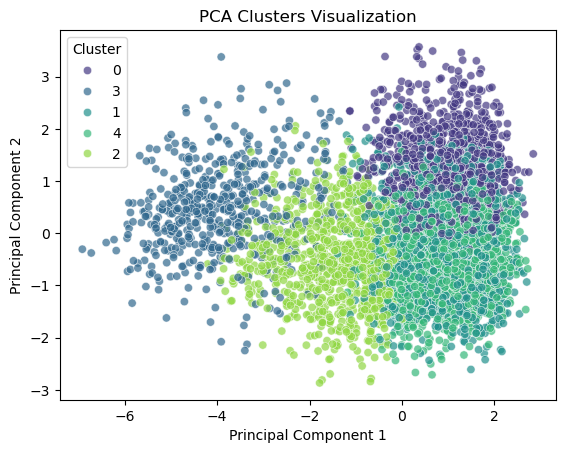

In [7]:
# Visualize PCA Clustering
sns.scatterplot(
    x=pca_df["PC1"], 
    y=pca_df["PC2"], 
    hue=pca_df["Cluster"].astype(str), 
    palette="viridis",
    alpha=0.7
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Clusters Visualization")
plt.legend(title="Cluster")
plt.show()

In [26]:
import pandas as pd
import difflib
from sklearn.metrics.pairwise import cosine_similarity

# Combine scaled features with original song info
df_scaled = pd.concat([df_sample.reset_index(drop=True), X_scaled_df.reset_index(drop=True)], axis=1)

# Remove duplicate columns that could cause errors
df_scaled = df_scaled.loc[:, ~df_scaled.columns.duplicated()]

# Define function to find closest matches for song names **with artist**
def find_closest_match(input_song, cutoff=0.6):
    """Finds the closest match to the input song name along with the artist."""
    song_list = df_scaled["track_name"].dropna().tolist()

    # **Exact match check before running similarity search**
    if input_song in song_list:
        matched_song = input_song
        matched_artist = df_scaled.loc[df_scaled["track_name"] == matched_song, "artist_name"].values[0]
        print(f"Match found: '{matched_song}' by {matched_artist}")
        return matched_song, matched_artist  # Use exact match directly

    # Fuzzy matching for closest name
    closest_match = difflib.get_close_matches(input_song, song_list, n=1, cutoff=cutoff)

    if closest_match:
        matched_song = closest_match[0]
        matched_artist = df_scaled.loc[df_scaled["track_name"] == matched_song, "artist_name"].values[0]
        print(f"Please check the spellings as there is no song named '{input_song}'. Closest match found: '{matched_song}' by {matched_artist}")
        return matched_song, matched_artist  # Return both song & artist
    else:
        return None, None  # No match found

# Define song recommendation function using cosine similarity
def recommend_song(input_song, cutoff=0.6, similarity_threshold=0.5):
    """Finds songs similar to the input song from different artists."""

    # Handle closest match if song isn't found
    matched_song, matched_artist = find_closest_match(input_song, cutoff)
    
    if not matched_song:
        return f"Song '{input_song}' not found."

    # Find the index of the matched song in df_sample (which matches X_scaled_df)
    matched_idx = df_sample[df_sample["track_name"] == matched_song].index
    if len(matched_idx) == 0:
        return f"Matched song '{matched_song}' not found in sample."

    # Get the scaled features for the matched song
    song_features = X_scaled_df.loc[matched_idx[0], numeric_features].values.reshape(1, -1)

    # Drop rows with missing values in X_scaled_df
    valid_rows = X_scaled_df.dropna(subset=numeric_features).index
    X_scaled_valid = X_scaled_df.loc[valid_rows, numeric_features]

    # Compute similarity
    similarities = cosine_similarity(song_features, X_scaled_valid)

    # Normalize similarity scores
    similarity_scores = similarities[0] / similarities[0].max()

    # Prepare recommendations DataFrame (exclude the original artist)
    df_valid = df_sample.loc[valid_rows].copy()
    df_valid["Similarity"] = similarity_scores

    input_artist = df_valid.loc[df_valid["track_name"] == matched_song, "artist_name"].values[0]
    recommendations = df_valid[(df_valid["artist_name"] != input_artist) & (df_valid["Similarity"] >= similarity_threshold)]

    # Sort by similarity first, then danceability & energy
    recommendations = recommendations.sort_values(by=["Similarity", "danceability", "energy"], ascending=[False, False, False]).head(10)

    if recommendations.empty:
        return f"No recommendations found for '{matched_song}'. Try adjusting filters or checking dataset."

    # **Return only track name and artist name**
    return recommendations[["track_name", "artist_name"]]

# Test Case
test_song = "I Love My Job"

# Run recommendation
recommended_songs = recommend_song(test_song)
recommended_songs.head()  # Display the top recommendations
# Display the top recommendations



Please check the spellings as there is no song named 'I Love My Job'. Closest match found: 'I Love My Job (Live)' by Bill Hicks


,track_name,artist_name
4728,Money Confusion,Brian Regan
2272,Deleted Scene,Darryl Lenox
3343,"Jack And Bobby In Hell, Alan Thicke, Polar Bea...",Bobcat Goldthwait
4710,My Theories,Bill Burr
2312,Strip Club,David Spade


In [9]:
# Save the PCA DataFrame to CSV for further analysis
pca_df.to_csv("resources/pca_results.csv", index=False)
# Save the scaled DataFrame to CSV for further analysis
df_scaled.to_csv("resources/scaled_features.csv", index=False)
# Save the original DataFrame with clusters to CSV for further analysis
df_sample.to_csv("resources/original_with_clusters.csv", index=False)